Following IEEE 802.11 - 2012

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from OFDM_transmit import OFDM_Tx
from OFDM_receive import OFDM_Rx
from Channel import channel


In [7]:
# -------------------------------------------Parameters

K = 64  # total number of OFDM subcarriers for (I)FFT computation
# OFDM_symb = 40 # number of complex numbers per OFDM symbol
CP = K//4  # length of the cyclic prefix: 25% of the block

# subcarrier indexing
all_subcarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilot_subcarriers = np.hstack([11, 25, 39, 53])

DC_subcarrier = np.hstack([32])

upper_training = all_subcarriers[:6]
lower_training = all_subcarriers[-5:]
training_subcarriers = np.concatenate((upper_training, lower_training))


data_subcarriers = np.delete(all_subcarriers, np.concatenate(
    (pilot_subcarriers, training_subcarriers, DC_subcarrier)))
print(len(data_subcarriers))


48


In [8]:
modulations = ["bpsk", "qpsk", "16qam", "64qam"]


SNRdb = np.arange(-3, 20, 2)


# Single OFDM symbol
BER = {}
N_bits = 2**10  # please select a power of 2 higher than 6
bits = np.random.binomial(n=1, p=0.5, size=(N_bits, ))
for i_mod in range(len(modulations)):
    modulation = modulations[i_mod]
    BER[i_mod] = np.zeros((len(SNRdb),), dtype=float)
# ------------------------------------Transmit
    OFDM_Tx1 = OFDM_Tx(modulation, training_subcarriers,
                       pilot_subcarriers, data_subcarriers, DC_subcarrier, CP, K)
    OFDM_withCP = OFDM_Tx1.bits2complex_stream(bits)
    for i_snr in range(len(SNRdb)):
        OFDM_Rx_signal = channel(OFDM_withCP, SNRdb[i_snr])

# ----------------------Receive--------------
        OFDM_Rx1 = OFDM_Rx(modulation, training_subcarriers,
                           pilot_subcarriers, data_subcarriers, DC_subcarrier, CP, K)
        bits_est = OFDM_Rx1.complex2bits(OFDM_Rx_signal)
        BER[i_mod][i_snr] = np.sum(
            abs(bits[:len(bits_est)]-bits_est))/len(bits_est)

    plt.semilogy(SNRdb, BER[i_mod], label=modulation)

plt.xlabel("SNR[dB]")
plt.ylabel("BER")
plt.legend()
plt.show()


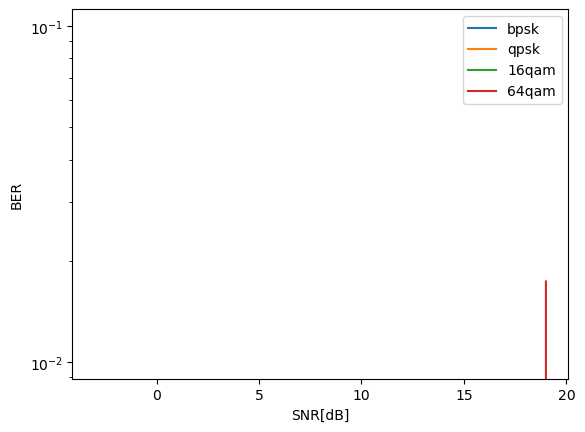

In [ ]:
# Multiple OFDM symbols
Num_ODFM_symbols = 1000
N_bits = 2**10  # please select a power of 2 higher than 6
BER = {}
for i_mod in range(len(modulations)):
    modulation = modulations[i_mod]
    print(modulation)
    BER[i_mod] = np.zeros((len(SNRdb),), dtype=float)
# ------------------------------------Tx & Rx objects
    OFDM_Tx1 = OFDM_Tx(modulation, training_subcarriers,
                       pilot_subcarriers, data_subcarriers, DC_subcarrier, CP, K)
    
    OFDM_Rx1 = OFDM_Rx(modulation, training_subcarriers,
                           pilot_subcarriers, data_subcarriers, DC_subcarrier, CP, K)
    bit_error_counter = np.zeros((len(SNRdb), Num_ODFM_symbols), dtype=float)       # keeps the error rate of each OFDM symbol 
    OFDM_bits_payload_counter = np.zeros((len(SNRdb), Num_ODFM_symbols), dtype=float)
    
    for i_snr in range(len(SNRdb)):
        for i_OFDM_symbol in range(Num_ODFM_symbols):
            bits = np.random.binomial(n=1, p=0.5, size=(N_bits, ))       
            OFDM_withCP = OFDM_Tx1.bits2complex_stream(bits)
            OFDM_Rx_signal = channel(OFDM_withCP, SNRdb[i_snr])
            bits_est = OFDM_Rx1.complex2bits(OFDM_Rx_signal)
            bit_error_counter[i_snr][i_OFDM_symbol]= np.sum(abs(bits[:len(bits_est)]-bits_est))
            OFDM_bits_payload_counter[i_snr][i_OFDM_symbol] = len(bits_est)

        BER[i_mod][i_snr] = sum(bit_error_counter[i_snr])/sum(OFDM_bits_payload_counter[i_snr])
    plt.semilogy(SNRdb, BER[i_mod], label=modulation)

plt.xlabel("SNR[dB]")
plt.ylabel("BER")
plt.legend()
plt.show()